In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader

In [3]:
%load_ext autoreload
%autoreload 2

## Dataset Setup

In [45]:
from make_analytic_table import AnalyticTableConstructor

atc = AnalyticTableConstructor(db_path="data/drafts.sqlite", validate_data=False)
X, y, y_names_mapping = atc.make_analytic_base_table()

In [46]:
N_CARDS = int(X.shape[1] / 2)

assert X.shape[1] == N_CARDS * 2

When there is more than one of a single card in a pack, we want to consider that just a single copy of that card for convenience.  Otherwise, we would have to apply this logic inside the model fitting logic, and track the gradient of this transformation.

In real (non-simulated) packs, this situation cannot happen anyway.

In [47]:
X.iloc[:, 0:N_CARDS] = np.sign(X.iloc[:, 0:N_CARDS])

In [48]:
train = TensorDataset(
    torch.from_numpy(X.values.astype(np.float32)),
    torch.from_numpy(y.values))
train_batcher = DataLoader(train, batch_size=42*50)

## Load and Fit the Model

In [63]:
from draftbot_learn import DraftBotModel

In [64]:
def loss_function(logps, ys):
    return -torch.mean(logps[range(ys.shape[0]), ys])

In [65]:
draftbot = DraftBotModel(n_cards=N_CARDS, n_archetypes=10)

In [66]:
def fit(model, train_batcher, *, n_epochs=25, learning_rate=0.005, alpha=0.001, report_freq=1):
    epoch_losses = []
    for epoch in range(n_epochs):
        batch_losses = []
        for Xb, yb in train_batcher:
            log_probs = model.forward(Xb)
            raw_loss = loss_function(log_probs, yb)
            regularized_loss = raw_loss + alpha * torch.sum(draftbot.weights ** 2)
            regularized_loss.backward()
            with torch.no_grad():
                batch_losses.append(raw_loss.item())
                draftbot.weights -= learning_rate * draftbot.weights.grad
                draftbot.weights.grad.zero_()
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        if epoch % report_freq == 0:
            print(f"Epoch {epoch} loss: {epoch_loss}")
    return epoch_losses

In [67]:
tl = fit(draftbot, train_batcher, n_epochs=25)

Epoch 0 loss: 1.2792276807500227
Epoch 1 loss: 0.7211850989458248
Epoch 2 loss: 0.5723510172841776
Epoch 3 loss: 0.48419212829743036
Epoch 4 loss: 0.4253738519158299
Epoch 5 loss: 0.3828793526774618
Epoch 6 loss: 0.35067045836966504
Epoch 7 loss: 0.32545011945709384
Epoch 8 loss: 0.3051788038258099
Epoch 9 loss: 0.2885250126883994
Epoch 10 loss: 0.2745874701784207
Epoch 11 loss: 0.26273834991913575
Epoch 12 loss: 0.2525291544010197
Epoch 13 loss: 0.24363166390500995
Epoch 14 loss: 0.23579985041559012
Epoch 15 loss: 0.22884563316182313
Epoch 16 loss: 0.22262247014639064
Epoch 17 loss: 0.21701458753908381
Epoch 18 loss: 0.2119292600661921
Epoch 19 loss: 0.20729150262353646
Epoch 20 loss: 0.2030401066687312
Epoch 21 loss: 0.1991246625511355
Epoch 22 loss: 0.1955033371823406
Epoch 23 loss: 0.19214117183135107
Epoch 24 loss: 0.1890087754410856


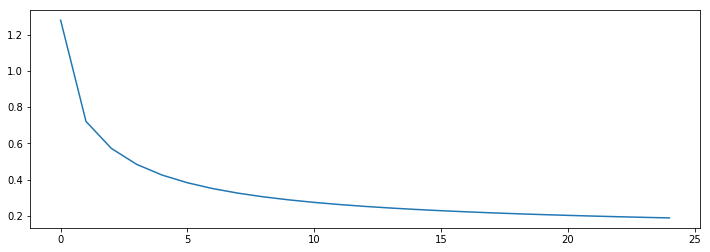

In [68]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(np.arange(len(tl)), tl)

## Constructing The Forward Pass

We're going to need a weight array which maps cards to their archetype weights.

In [ ]:
weights = torch.FloatTensor(N_CARDS, 10).uniform_(0.0, 1.0)
weights.requires_grad_()

In [ ]:
options, cards = X_batch[:, :N_CARDS], X_batch[:, N_CARDS:]

assert cards.shape == options.shape

In [ ]:
current_archetype_preferences = cards @ weights + 1

In [ ]:
current_archetype_preferences.shape

In [ ]:
option_weights = options.view((42*10, 25, 1)) * weights.reshape((1, 25, 10))

In [ ]:
current_archetype_preferences.shape, option_weights.shape

In [ ]:
current_option_preferences = torch.einsum('pw,pcw->pc', current_archetype_preferences, option_weights)

In [ ]:
current_option_preferences.shape

In [ ]:
pick_probabilities = non_zero_softmax(current_option_preferences)

In [ ]:
loss.backward()

In [ ]:
print(weights.grad)

Lets try to put this in a function and actually try to fit the damn thing.

In [ ]:
LEARNING_RATE = 0.005
N_EPOCHS = 50

In [ ]:
weights = torch.FloatTensor(N_CARDS, 10).uniform_(0.0, 1.0)
_ = weights.requires_grad_()

In [ ]:
def stable_non_zero_log_softmax(x):
    b = x.max(dim=1).values.view(-1, 1)
    stabalized_x = (x - b * x.sign())
    log_probs = (
        x.sign() * 
        (stabalized_x - torch.log(torch.sum(x.sign() * torch.exp(stabalized_x), dim=1)).view(-1, 1)))
    return log_probs

In [ ]:
def loss_function(logps, ys):
    return -torch.mean(logps[range(ys.shape[0]), ys])

In [ ]:
batch_losses = []

for epoch in range(N_EPOCHS):
    print("Epoch", epoch)
    for batch_num, (Xb, yb) in enumerate(train_batcher):
        options, cards = Xb[:, :N_CARDS], Xb[:, N_CARDS:]
        archetype_preferences = cards @ weights + 1
        option_weights = options.view((Xb.shape[0], 25, 1)) * weights.reshape((1, 25, 10))
        current_option_preferences = torch.einsum('pw,pcw->pc', archetype_preferences, option_weights)
        probs = stable_non_zero_log_softmax(current_option_preferences)
        #print("Mean Prob Pick:", torch.mean(probs[range(yb.shape[0]), yb]))
        raw_loss = loss_function(probs, yb)
        regularized_loss = raw_loss + 0.001 * torch.sum(weights ** 2)
        regularized_loss.backward()
        with torch.no_grad():
            batch_losses.append(raw_loss.item())
            weights -= LEARNING_RATE * weights.grad
            weights.grad.zero_()
        if batch_num % 100 == 0:
            print(np.mean(batch_losses))
            batch_losses = []
            #print("Mean Prob Pick:", torch.mean(probs[range(yb.shape[0]), yb]))
            #print("Current option preferences:", current_option_preferences[0])
            #print("Current probs:", probs[0])

In [ ]:
class DraftBotLearn(torch.nn.Module):
    
    def __init__(self, *, n_cards, n_archetypes):
        super().__init__()
        self.n_cards = n_cards
        self.n_archetypes = n_archetypes
        self.weights = torch.nn.Parameter(
            torch.FloatTensor(n_cards, n_archetypes).uniform_(0.0, 1.0))
    
    def forward(self, X):
        options, cards = Xb[:, :self.n_cards], Xb[:, self.n_cards:]
        archetype_preferences = cards @ weights + 1
        option_weights = (
            options.view((X.shape[0], self.n_cards, 1))
            * self.weights.reshape((1, self.n_cards, self.n_archetypes)))
        current_option_preferences = torch.einsum(
            'pw,pcw->pc', archetype_preferences, option_weights)
        log_probs = stable_non_zero_log_softmax(current_option_preferences)
        return log_probs

In [ ]:
draftbot = DraftBotLearn(n_cards=25, n_archetypes=10)
batch_losses = []

for epoch in range(N_EPOCHS):
    print("Epoch", epoch)
    for batch_num, (Xb, yb) in enumerate(train_batcher):
        log_probs = draftbot.forward(Xb)
        #print("Mean Prob Pick:", torch.mean(probs[range(yb.shape[0]), yb]))
        raw_loss = loss_function(log_probs, yb)
        regularized_loss = raw_loss + 0.001 * torch.sum(weights ** 2)
        regularized_loss.backward()
        with torch.no_grad():
            batch_losses.append(raw_loss.item())
            draftbot.weights -= LEARNING_RATE * draftbot.weights.grad
            draftbot.weights.grad.zero_()
        if batch_num % 100 == 0:
            print(np.mean(batch_losses))
            batch_losses = []
            #print("Mean Prob Pick:", torch.mean(probs[range(yb.shape[0]), yb]))
            #print("Current option preferences:", current_option_preferences[0])
            #print("Current probs:", probs[0])

In [ ]:
weights_df = pd.DataFrame(weights.detach().numpy(), index=y_names_mapping.values())

In [ ]:
weights_df

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(weights_df.T.corr().values)

ax.set_xticks(np.arange(len(weights_df)))
ax.set_yticks(np.arange(len(weights_df)))
# ... and label them with the respective list entries
ax.set_xticklabels(weights_df.index)
ax.set_yticklabels(weights_df.index)

_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(weights_df.values)

ax.set_yticks(np.arange(len(weights_df)))
_ = ax.set_yticklabels(weights_df.index)

In [ ]:
weights_df.sum(axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(weights_df.corr().values)

#ax.set_xticks(np.arange(len(weights_df)))
#ax.set_yticks(np.arange(len(weights_df)))
# ... and label them with the respective list entries
#ax.set_xticklabels(weights_df.index)
#ax.set_yticklabels(weights_df.index)

#_ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")